# Topic Modeling with Eugenics Articles

## Import Data

Get data from picklefiles and store in DataFrame

In [1]:
import pickle
import pandas as pd 
import os

filenames = os.listdir('equarterly_clean_articles/')

dicts = []

for file in filenames:
    infile = open('equarterly_clean_articles/' + file,'rb')
    corp_dict = pickle.load(infile)
    dicts.append(corp_dict)
    infile.close
    
df = pd.DataFrame(dicts)

df['title'] = df['title'].str.lower()
df['content'] = df['content'].str.lower()
df['year'] = pd.to_numeric(df['year'])
df

,title,year,publisher,content,has_ref,references,start_page
0,meetings and recent publications,1961,Eugenics Quarterly,organization reports: association for the ai...,False,,171
1,notes at the conclusion of the second princeto...,1966,Eugenics Quarterly,"the purpose of this meeting, as i understand...",False,,147
2,discussions on the teaching of genetics to med...,1961,Eugenics Quarterly,i n october 1961 at the rockefeller instit...,False,,223
3,a return to the principles of natural selection,1960,Eugenics Quarterly,editor's note: it is generally agreed that m...,False,,204
4,color blindness among korean students,1967,Eugenics Quarterly,introduction sexlinked defects in color visi...,True,"KALMUS, HANS, 1965 . Diagnosis and Genetics ...",271
...,...,...,...,...,...,...,...
398,the effect of unwanted pregnancies on a relief...,1961,Eugenics Quarterly,i. background of investigation jcrom the dat...,True,"BUELL, BRADLEY, AND ASSOCIATES. 1952 . Commu...",142
399,fertility differentials among economic strata ...,1960,Eugenics Quarterly,x he pattern of population growth in india w...,False,,77
400,"selection against ""colorblindness"" among ""prim...",1965,Eugenics Quarterly,"selection against ""colorblindness"" among ""pr...",True,"Li, C. C., 1955 . Population Genetics. Unive...",28
401,a further note on evolution and schizophrenia,1967,Eugenics Quarterly,"the comments by kuttner and lorincz ( 1966 ,...",True,"HUXLEY, J., E. MAYR, H. OSMOND, and A. HOFFER...",158


## ***Tokenize with NLTK***
### In general, there are two levels of tokenization: sentence level and word level.

In [2]:
import nltk

In [3]:
# download the nltk data

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/zeke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [5]:
df["title_token"] = df['title'].apply(word_tokenize)

# ***Stemming with NLTK***

#### The concept of stemming is a standardized method. Except for tense, many variations of words have the same meaning. To understand stem technique, consider the following:

- #### ***I like writing python code in a pythonic way.***
- #### ***I like pythoning pythonic python code.***

#### As you may see, although the two sentence vary in terms of using ***python***, however, the stem of the two sentences is the same: **python**

In [6]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [7]:
# def stem_list(tokens):
#     new_tokens = []
#     for token in tokens:
#         new_tokens.append(ps.stem(token.lower()))
    
#     return new_tokens

# df['title_token'] = df['title_token'].apply(stem_list)

# df['title_token']

# ***Lemmatizing with NLTK***

#### An operation very similar to stemming is called lemmatizing. The main difference between the two is that, stemming can create non-existent vocabulary.Let's look at some examples.

In [8]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lem_list(tokens):
    new_tokens = []
    for token in tokens:
        new_tokens.append(lemmatizer.lemmatize(token))
    
    return new_tokens

df['title_token'] = df['title_token'].apply(lem_list)

df['title_token']

[nltk_data] Downloading package wordnet to /Users/zeke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                    [meeting, and, recent, publication]
1      [note, at, the, conclusion, of, the, second, p...
2      [discussion, on, the, teaching, of, genetics, ...
3      [a, return, to, the, principle, of, natural, s...
4             [color, blindness, among, korean, student]
                             ...                        
398    [the, effect, of, unwanted, pregnancy, on, a, ...
399    [fertility, differential, among, economic, str...
400    [selection, against, ``, colorblindness, '', a...
401    [a, further, note, on, evolution, and, schizop...
402        [genetic, signpost, of, preventive, medicine]
Name: title_token, Length: 403, dtype: object

#### Note that if you do not  assign the *pos* parameter, it will default to **'n'** (noun).

# ***Stop words removal with NLTK***

#### The process of converting data into something the computer can understand is called pre-processing. One of the main forms of preprocessing is to filter out *useless* data. In NLP, the useless words (data) are called **stop words**.

#### The key assumption behinds this is: ***Some words are more meaningful than others***.

In [9]:
from nltk.corpus import stopwords

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/zeke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stop(tokens):
    stop_words = set(stopwords.words('english'))
    stop_words.add('``')
    stop_words.add("''")
    stop_words.add(',')
    stop_words.add(":")
    stop_words.add("'s")
    stop_words.add(".")
    stop_words.add(")")
    stop_words.add("(")
    stop_words.add("?")
    
    new_tokens = [w for w in tokens if not w in stop_words]
    return new_tokens

df['title_token'] = df['title_token'].apply(remove_stop)

df['title_token']

0                         [meeting, recent, publication]
1      [note, conclusion, second, princeton, conferen...
2      [discussion, teaching, genetics, medical, stud...
3                [return, principle, natural, selection]
4             [color, blindness, among, korean, student]
                             ...                        
398    [effect, unwanted, pregnancy, relief, load, ex...
399    [fertility, differential, among, economic, str...
400    [selection, colorblindness, among, primitive, ...
401                     [note, evolution, schizophrenia]
402            [genetic, signpost, preventive, medicine]
Name: title_token, Length: 403, dtype: object

# **Topic Modeling With LDA**

In [12]:
from gensim import corpora
import gensim


text_data = df[df['year'] <= 1959]['title_token']
dictionary1 = corpora.Dictionary(text_data)
corpus1 = [dictionary1.doc2bow(text) for text in text_data]

NUM_TOPICS = 3
ldamodel1 = gensim.models.ldamodel.LdaModel(corpus1, num_topics = NUM_TOPICS, id2word=dictionary1, passes=15)
topics = ldamodel1.print_topics(num_words=4)

text_data = df[df['year'] > 1959]['title_token']
dictionary2 = corpora.Dictionary(text_data)
corpus2 = [dictionary2.doc2bow(text) for text in text_data]

NUM_TOPICS = 3
ldamodel2 = gensim.models.ldamodel.LdaModel(corpus2, num_topics = NUM_TOPICS, id2word=dictionary2, passes=15)
topics = ldamodel2.print_topics(num_words=4)


In [13]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel1, corpus1, dictionary1, sort_topics=False)
pyLDAvis.display(lda_display)

In [14]:
lda_display = pyLDAvis.gensim.prepare(ldamodel2, corpus2, dictionary2, sort_topics=False)
pyLDAvis.display(lda_display)

## Word Cloud Visualization

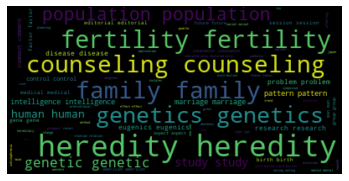

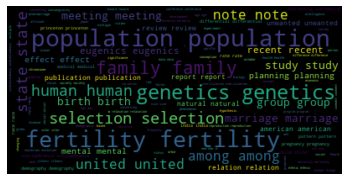

In [32]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

def get_tokens(df):
    for index, row in df.iterrows():
        for token in row['title_token']:
            yield token

            
token_freq = dict(Counter(get_tokens(df[df['year'] < 1960])))
text = " ".join([(k + " ")*v for k,v in token_freq.items()])
wordcloud = WordCloud().generate(text)

_ = plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")
_ = plt.show()

token_freq = dict(Counter(get_tokens(df[df['year'] >= 1960])))
text = " ".join([(k + " ")*v for k,v in token_freq.items()])
wordcloud = WordCloud().generate(text)

_ = plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")
_ = plt.show()